In [1]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.7 MB/s eta 0:00:00


In [2]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models
import tensorflow as tf


Segmentation Models: using `tf.keras` framework.


In [3]:
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Input, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
path = "/content/drive/MyDrive/Visea_KITTI_Dataset/"

In [6]:
X = os.listdir(path + '/Train/Images')
X.sort()

In [7]:
y = os.listdir(path + 'Train/Ground Truth')
y.sort()

In [8]:
X_test = os.listdir(path + '/Test/Images')
X_test.sort()

In [9]:
y_test = os.listdir(path + '/Test/Ground Truth')
y_test.sort()

In [10]:
train_img_list = []
masked_train_valid_img_list = []

def imgPreprocessing(file, maskedFile):
    for i in file:
        image = cv2.imread(path + 'Train/Images/' + i)
        image = cv2.resize(image,(128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0
        train_img_list.append(image)

    for j in maskedFile:
        masked_image = cv2.imread(path + 'Train/Ground Truth/' + j)
        masked_image = cv2.resize(masked_image,(128, 128))
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = masked_image/255.0
        masked_train_valid_img_list.append(masked_image)

In [11]:
test_img_list = []
masked_test_img_list = []

def testImgPreprocessing(file, maskedFile):
    for i in file:
        image = cv2.imread(path + 'Test/Images/' + i)
        image = cv2.resize(image,(128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0
        test_img_list.append(image)

    for j in maskedFile:
        masked_image = cv2.imread(path + 'Test/Ground Truth/' + j)
        masked_image = cv2.resize(masked_image,(128, 128))
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = masked_image/255.0
        masked_test_img_list.append(masked_image)

In [12]:
testImgPreprocessing(X_test, y_test)

In [13]:
imgPreprocessing(X, y)

In [14]:
test_images = np.array(test_img_list)
test_ground_truth_images = np.array(masked_test_img_list)

In [15]:
train_images = np.array(train_img_list)
train_ground_truth_images = np.array(masked_train_valid_img_list)

In [16]:
print(test_images.shape)
print(test_ground_truth_images.shape)

(25, 128, 128, 3)
(25, 128, 128, 3)


In [17]:
print(train_images.shape)
print(train_ground_truth_images.shape)

(175, 128, 128, 3)
(175, 128, 128, 3)


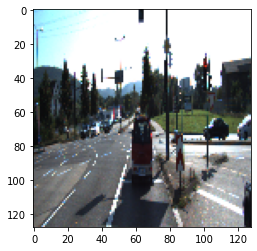

In [18]:
plt.imshow(train_images[19])

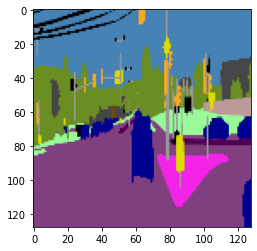

In [19]:
plt.imshow(train_ground_truth_images[19])

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_ground_truth_images, test_size=0.2, random_state=42)

print(len(X_train), len(X_valid), len(y_train), len(y_valid))

140 35 140 35


In [21]:
inputs = tf.keras.Input(shape=(128, 128, 3))
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
drop4 = Dropout(0.5)(conv4)
    

conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)
    

up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([conv3,up6], axis = 3)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv2,up7], axis = 3)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv1,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv9 = Conv2D(3, 1, activation = 'softmax')(conv8)

model = tf.keras.Model(inputs = inputs, outputs = conv9)

model.compile(optimizer = Adam(lr = 0.005), loss = ['binary_crossentropy'], metrics = ['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, y_valid)

2/2 [==============================] - 0s 19ms/step - loss: 0.6089 - accuracy: 0.7934


[0.6088759303092957, 0.7934064865112305]

In [36]:
predictions = model.predict(test_images)

1/1 [==============================] - 0s 25ms/step


In [97]:
def detect_object(pred_image, original_image, model):

  pred_image = pred_image*255

  lower_bound = (11. - 5, 8. - 5, 232. - 5) # Change according your color scale
  upper_bound = (11. + 5, 8. + 5, 232. + 5) # Change according your color scale

  mask = cv2.inRange(pred_image, lower_bound, upper_bound)
  count = cv2.countNonZero(mask)
  print(f"picture contains {count} pixels of that color")

  detected_image = cv2.rectangle(original_image, (mask.nonzero()[0].min(), mask.nonzero()[0].max()), (mask.nonzero()[1].min(), mask.nonzero()[1].max()), (255, 0, 0), 1)
  plt.imshow(detected_image)

picture contains 27 pixels of that color


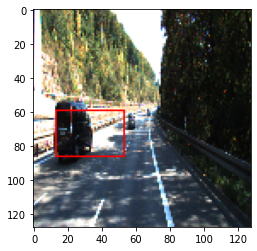

In [107]:
detect_object(predictions[7], test_images[7], model)

picture contains 4 pixels of that color


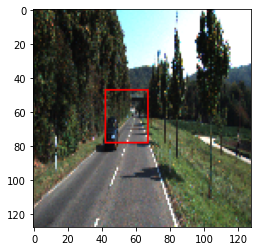

In [99]:
detect_object(predictions[23], test_images[23], model)

picture contains 97 pixels of that color


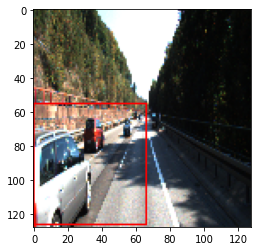

In [106]:
detect_object(predictions[10], test_images[10], model)

picture contains 42 pixels of that color


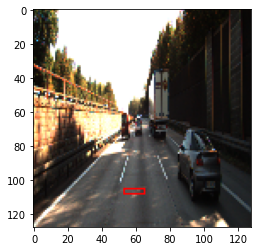

In [108]:
detect_object(predictions[14], test_images[14], model)

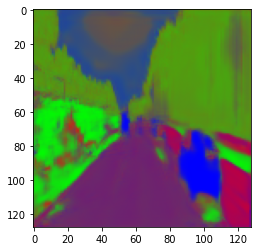

In [109]:
plt.imshow(predictions[14])

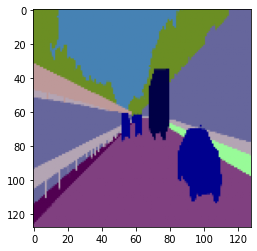

In [105]:
plt.imshow(test_ground_truth_images[14])

In [39]:
#plt.imsave('img_22.jpg',predictions[22])

In [102]:
#model.save("model.h5")

In [38]:
#from tensorflow.keras.models import load_model
#modeltest = load_model('/content/model.h5')